LOADING THE TEMPERATURE DATA

In [1]:
#Create path to the data within the drive folder

import numpy as np
import pandas as pd
import os
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta

import glob

from matplotlib import pyplot as plt
import datetime

#Path to the main folder
Path = 'Temperature_data/Temperature_data/'
filelist = os.listdir(Path)


#Path to the multiple subfolders within the main folder
Path2 = []
for x in filelist:
    if x.startswith('Temperature'):
        Path2.append(Path + x+ '/')


#Obtaining all the files within the subfolders and storing them into a list of dataframes (20 elements within the lsit - 10 towns each with 2 dataframes (first from 2011 to 2021 then 2021 to 2022))
dataframe = []
new_names = {'YEAR': 'Year', 'MO': 'Month', 'DY': 'Day', 'HR': 'Hour', 'T2M': 'Town_0' }
path3 = [] #list of the different files. Print it out to ensure that we are appending the data in the right order
for i in Path2:
  filelist2 = os.listdir(i)
  for j in filelist2:
    if j.endswith('.csv'):
      path3.append(i+j)
      df = pd.read_csv(i+j, sep=',', header=0, skiprows=9, index_col = None)
      df = df.rename(columns=new_names)
      median_replacer = df['Town_0'].quantile(0.15)
      upper_q = df['Town_0'].quantile(0.005)
      df['Town_0'] = np.where(df['Town_0'] < upper_q, median_replacer, df['Town_0'])
      df['time'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
      df = df.drop(df.columns[[0, 1 ,2,3]], axis = 1)
      dataframe.append(df)

#Confirming that all the dataframes are of the appropriate length and then replacing the one that is not
print(len(dataframe[0]), len(dataframe[1]), len(dataframe[2]), len(dataframe[3]), len(dataframe[4]), len(dataframe[5]), len(dataframe[6]), len(dataframe[7]))


#Appending the dataframes in pairs such that we have a dataframe for each town running from 2011 to 2022
merged_list_ = [] #contains time column as well
merged_list = [] #time column dropped
for i in range(0, len(dataframe), 2):
  merge_list = [dataframe[i], dataframe[i+1]]
  merge = pd. concat(merge_list, axis=0, ignore_index=True)
  merged_list_.append(merge)
  merge = merge.drop('time', axis = 1)
  merged_list.append(merge)


#Appending all the wind speed data from the different towns into a single dataframe - each town has its own column
temp_df = merged_list[0]
for df in merged_list[1:]:
    for column in df.columns:
        if column in temp_df.columns:
            new_column_name = column + str(len(temp_df.columns))
            temp_df[new_column_name] = df[column]
        else:
            temp_df[column] = df[column]

#retrieve date data from the original dataframe, adding the one-hour time element then appending to dataframe
date = pd.to_datetime(merged_list_[0]['time'].iloc[0]) #the first date entry
timestamps = [] #the corresponding timestamps except with the hour added to make them unique hence column can be set as index
for i in range(0, len(temp_df), 1):
    timestamps.append(date + timedelta(hours=i))
temp_df['date'] = timestamps #assign the new time list

#Rearranging columns to have date as first item
cols = temp_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
temp_df = temp_df[cols]

#Computing the average temperature and appending that to new column
temp_df['av_temp'] = temp_df.iloc[:, 1:].mean(axis=1)

#Filter for only pre-covid demand
temp_df = temp_df[temp_df['date'] < '2020-01-01 00:00:00']
temp_df = temp_df[temp_df['date'] > '2014-12-31 23:30:00']

#Reset the index to identify the split points better later
temp_df = temp_df.reset_index(drop = True)

temp_df.tail(10)

87672 17520 87672 17520 87672 17520 87672 17520


C:\Users\User\AppData\Local\Temp\ipykernel_10336\11999920.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['av_temp'] = temp_df.iloc[:, 1:].mean(axis=1)


,date,Town_0,Town_01,Town_02,Town_03,Town_04,Town_05,Town_06,Town_07,Town_08,...,Town_034,Town_035,Town_036,Town_037,Town_038,Town_039,Town_040,Town_041,Town_042,av_temp
43814,2019-12-31 14:00:00,8.23,7.81,7.99,8.77,8.20,7.83,6.88,8.48,6.95,...,6.18,3.05,2.23,1.22,3.63,6.25,7.87,5.08,5.23,5.396047
43815,2019-12-31 15:00:00,7.99,7.57,7.80,8.35,8.07,7.74,7.08,7.82,5.53,...,5.85,2.04,0.58,-0.33,3.07,5.86,7.87,4.37,4.60,4.576279
43816,2019-12-31 16:00:00,7.87,7.43,7.65,7.89,7.91,7.68,7.37,7.41,5.26,...,5.72,1.32,0.27,-0.55,2.90,5.73,7.92,4.24,4.54,4.325116
43817,2019-12-31 17:00:00,7.84,7.44,7.63,7.30,7.58,7.59,7.55,7.38,5.67,...,5.81,1.04,0.29,-0.52,2.71,5.83,8.08,4.08,4.42,4.350698
43818,2019-12-31 18:00:00,7.83,7.50,7.61,7.04,6.87,7.41,7.50,7.22,5.73,...,5.99,0.73,0.19,-0.54,2.88,6.05,8.23,3.90,4.38,4.389767
43819,2019-12-31 19:00:00,7.88,7.48,7.56,6.86,6.61,7.15,7.40,6.86,5.73,...,6.41,0.33,0.12,-0.31,3.09,6.31,8.34,3.81,4.37,4.443721
43820,2019-12-31 20:00:00,7.93,7.45,7.48,6.62,6.42,6.86,7.29,6.40,5.50,...,6.91,-0.06,0.33,0.19,3.45,6.61,8.41,3.70,4.34,4.523488
43821,2019-12-31 21:00:00,7.93,7.42,7.38,6.06,6.20,6.51,7.09,5.64,5.29,...,7.39,-0.10,0.41,0.33,3.94,6.85,8.52,3.47,4.25,4.571628
43822,2019-12-31 22:00:00,7.97,7.40,7.33,4.58,5.88,6.22,6.88,4.95,5.16,...,7.65,-0.26,0.55,0.95,4.56,7.13,8.67,3.50,4.42,4.589070
43823,2019-12-31 23:00:00,8.00,7.30,7.33,3.26,5.31,5.89,6.44,4.29,4.93,...,7.80,-0.63,1.07,2.15,5.22,7.35,8.83,3.65,4.67,4.657442


PICKING THE RELEVANT COLUMNS

In [2]:
# List of column names you want to select
columns_to_select = ['date', 'av_temp']
# Create a new DataFrame with the selected columns
df_demand = temp_df[columns_to_select]
#Creating the time column to be used later
df_demand['time'] =df_demand['date'].dt.time
# Convert the datetime.time object to a string in your desired format
df_demand['time_str'] = df_demand['time'].apply(lambda x: x.strftime('%H:%M:%S'))



#Uncomment to peep into the dataframe
#
#print(len(df_demand))
df_demand

C:\Users\User\AppData\Local\Temp\ipykernel_10336\3238024084.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demand['time'] =df_demand['date'].dt.time
C:\Users\User\AppData\Local\Temp\ipykernel_10336\3238024084.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demand['time_str'] = df_demand['time'].apply(lambda x: x.strftime('%H:%M:%S'))


,date,av_temp,time,time_str
0,2015-01-01 00:00:00,7.468140,00:00:00,00:00:00
1,2015-01-01 01:00:00,7.496047,01:00:00,01:00:00
2,2015-01-01 02:00:00,7.599535,02:00:00,02:00:00
3,2015-01-01 03:00:00,7.757442,03:00:00,03:00:00
4,2015-01-01 04:00:00,7.916047,04:00:00,04:00:00
...,...,...,...,...
43819,2019-12-31 19:00:00,4.443721,19:00:00,19:00:00
43820,2019-12-31 20:00:00,4.523488,20:00:00,20:00:00
43821,2019-12-31 21:00:00,4.571628,21:00:00,21:00:00
43822,2019-12-31 22:00:00,4.589070,22:00:00,22:00:00


Checking the null values

In [3]:
nan_count = df_demand['av_temp'].isna().sum()
print(nan_count)

0


Mapping the date to the corresponding days of the week (including the ones that are holidays)

In [4]:
# Extract the day of the week (0=Monday, 1=Tuesday, ..., 6=Sunday)
df_demand['day'] = df_demand['date'].dt.dayofweek

# Define a dictionary to map day of the week to corresponding names
day_names = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

# Map the day of the week to day names
df_demand['day'] = df_demand['day'].map(day_names)
uk_bank_holidays = [
    '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01',
    '2015-04-03', '2016-03-25', '2017-04-14', '2018-03-30',
    '2015-04-06', '2016-03-28', '2017-04-17', '2018-04-02',
    '2015-05-04', '2016-05-02', '2017-05-01', '2018-05-07',
    '2015-05-25', '2016-05-30', '2017-05-29', '2018-05-28',
    '2015-08-31', '2016-08-29', '2017-08-28', '2018-08-27',
    '2015-12-25', '2016-12-25', '2017-12-25', '2018-12-25',
    '2015-12-26', '2016-12-26', '2017-12-26', '2018-12-26'
]

df_demand.loc[df_demand['date'].dt.strftime('%Y-%m-%d').isin(uk_bank_holidays), 'day'] = 'Holiday'
df_demand

C:\Users\User\AppData\Local\Temp\ipykernel_10336\3902297685.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demand['day'] = df_demand['date'].dt.dayofweek
C:\Users\User\AppData\Local\Temp\ipykernel_10336\3902297685.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demand['day'] = df_demand['day'].map(day_names)


,date,av_temp,time,time_str,day
0,2015-01-01 00:00:00,7.468140,00:00:00,00:00:00,Holiday
1,2015-01-01 01:00:00,7.496047,01:00:00,01:00:00,Holiday
2,2015-01-01 02:00:00,7.599535,02:00:00,02:00:00,Holiday
3,2015-01-01 03:00:00,7.757442,03:00:00,03:00:00,Holiday
4,2015-01-01 04:00:00,7.916047,04:00:00,04:00:00,Holiday
...,...,...,...,...,...
43819,2019-12-31 19:00:00,4.443721,19:00:00,19:00:00,Tuesday
43820,2019-12-31 20:00:00,4.523488,20:00:00,20:00:00,Tuesday
43821,2019-12-31 21:00:00,4.571628,21:00:00,21:00:00,Tuesday
43822,2019-12-31 22:00:00,4.589070,22:00:00,22:00:00,Tuesday


Filtering to get the averages for each day and appending this to a new dataframe

In [5]:
# Filter rows where 'day' column is equal to 'Thursday'
days = ['Holiday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

#Creating the empty dataframe
result_df = pd.DataFrame() 

#Extracting time elements from the 
result_df['time'] = df_demand['time_str'][0:25]
result_df


for day in days:
    day_frame = df_demand[df_demand['day'] == day]

    #Exxtracting time from the datetime column and saving it to a new column
    day_frame['time'] = day_frame['date'].dt.time

    # Group by 'day_type' and calculate the sum of demand
    grouped = day_frame.groupby('time')['av_temp'].mean().reset_index()

    #Renaming the column with the right name
    grouped = grouped.rename(columns={'av_temp': day})


    # # Merge the grouped DataFrame back into the original DataFrame
    # df_demand = df_demand.merge(grouped, on='time', how='left')
    
    #Appending that to the empty dataframe
    result_df = pd.concat([result_df, grouped[day]], axis=1)

result_df

C:\Users\User\AppData\Local\Temp\ipykernel_10336\1550827230.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_frame['time'] = day_frame['date'].dt.time
C:\Users\User\AppData\Local\Temp\ipykernel_10336\1550827230.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_frame['time'] = day_frame['date'].dt.time
C:\Users\User\AppData\Local\Temp\ipykernel_10336\1550827230.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

,time,Holiday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,00:00:00,7.308020,7.723125,7.913967,8.014857,7.928119,7.831329,7.887078,7.840469
1,01:00:00,7.199471,7.586876,7.777233,7.874648,7.783004,7.688714,7.750971,7.695683
2,02:00:00,7.092431,7.475480,7.660294,7.754702,7.657390,7.569845,7.632922,7.570627
3,03:00:00,6.997421,7.391242,7.568465,7.660275,7.553229,7.479599,7.538610,7.462527
4,04:00:00,6.944503,7.389982,7.565556,7.646973,7.532774,7.481343,7.532113,7.440646
5,05:00:00,7.038739,7.593024,7.789122,7.838786,7.720225,7.690194,7.729417,7.629661
6,06:00:00,7.385426,7.947286,8.167646,8.190624,8.079308,8.061045,8.107126,8.004977
7,07:00:00,7.833545,8.457276,8.702084,8.714683,8.611144,8.590144,8.633471,8.541488
8,08:00:00,8.344461,9.104386,9.358528,9.363647,9.273561,9.237070,9.257743,9.199257
9,09:00:00,8.947618,9.821478,10.058076,10.057595,9.976850,9.938484,9.932572,9.912458


Now generating the line plot

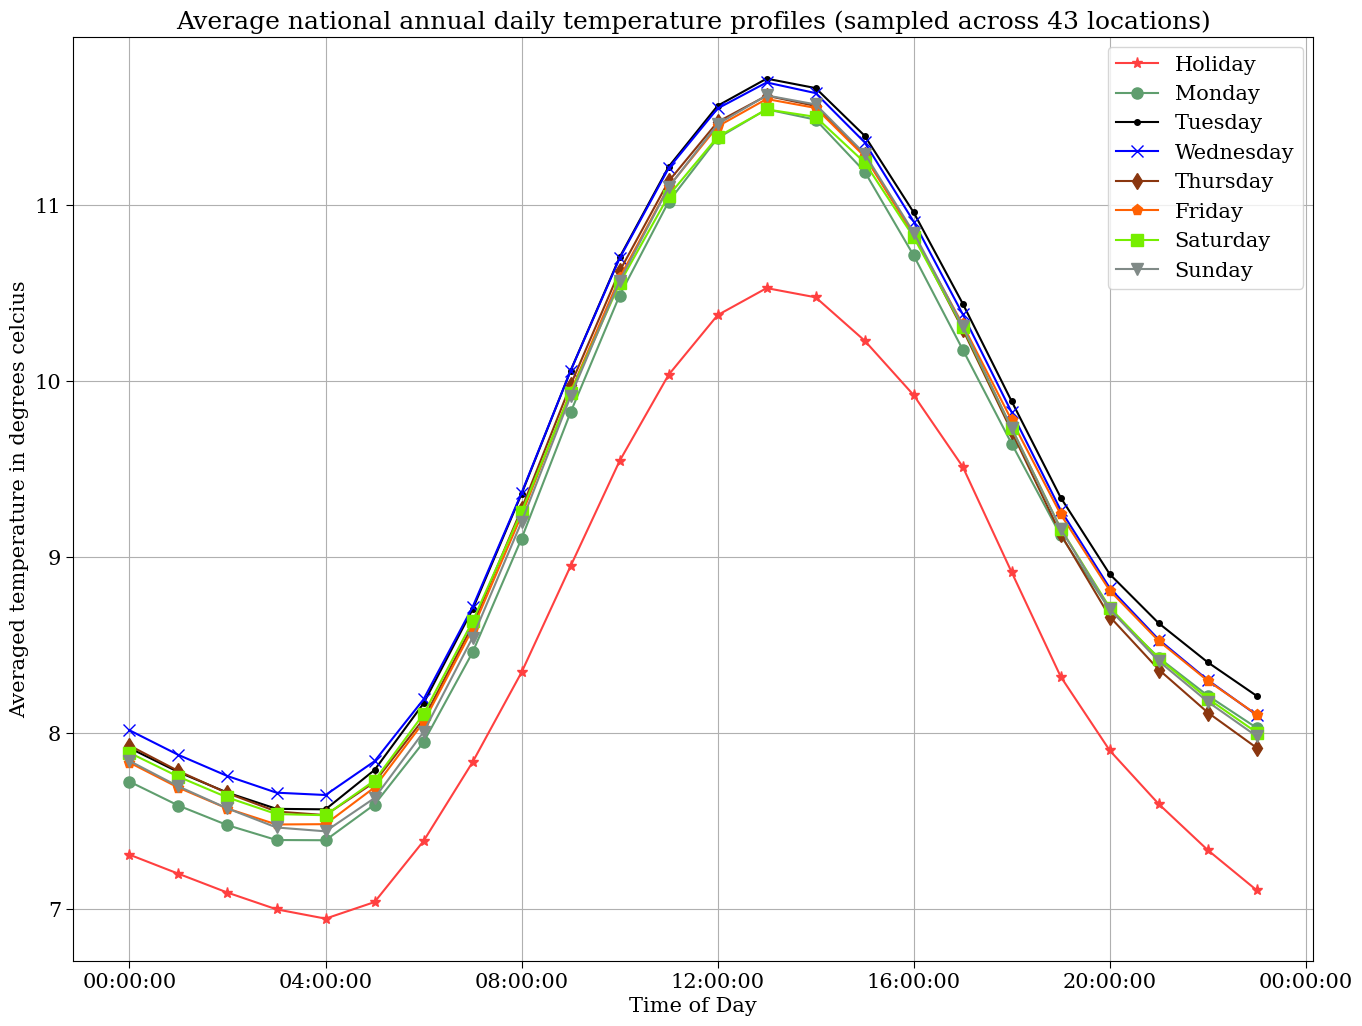

In [7]:
from matplotlib import pyplot as plt
colors = ['#FF4040', '#5f9e6e', '#000000', '#0000FF', '#8A360F', '#FF6103', '#76EE00', '#808A87']
markers = ['*','o','.','x','d','p', 's', 'v']

plt.rcParams.update(
    {
        "lines.markersize": 8,  # Big points
        "font.size": 15,  # Larger font
        "font.family": 'serif',
        "xtick.major.size": 5.0,  # Bigger xticks
        "ytick.major.size": 5.0,  # Bigger yticks
    }
)

fig, ax = plt.subplots(figsize = (16,12))
for index, day in enumerate(days):
    ax.plot(result_df['time'], result_df[day], color = colors[index], marker = markers[index], label = day)

ax.set_xlabel('Time of Day')
ax.set_ylabel('Averaged temperature in degrees celcius')
tick_positions = range(0, len(result_df['time']), 4)
tick_labels = [result_df['time'][i] for i in tick_positions]
# Set the x-tick positions and labels
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)
ax.set_title('Average national annual daily temperature profiles (sampled across 43 locations)')
ax.grid()
ax.legend(loc = 'best')